### 📁 Data Loading and Label Extraction

In this cell, `.csv` files from the PM_980 dataset are listed. Each file represents a signal sample, and its corresponding class label is extracted from the filename (e.g., `healthy`, `scratch`, `twocutshort`, etc.).

Additionally, 8 sensor columns are defined for extracting time and frequency domain features:

- `Voice` (Sound sensor)
- `Acceleration X`, `Y`, `Z` (Accelerometer data)
- `Gyro X`, `Y`, `Z` (Gyroscope data)
- `Temperature` (Temperature sensor)

These signals will be used as input features for the model. The data is sampled at 90 Hz.

The `get_label` function identifies the class label of each sample based on its filename. It also includes a basic check for potential typos in class names to ensure accurate labeling.


In [1]:
import os
import pandas as pd
import numpy as np
import glob
from scipy.stats import skew, kurtosis
from scipy.fft import rfft, rfftfreq

DATASET_DIR = '/content/drive/MyDrive/PM980'
csv_files = [file for file in os.listdir(DATASET_DIR) if file.endswith('.csv')]
RANDOM_SEED = 13

# Sensor columns to extract time/frequency features from
SENSOR_COLUMNS = [
    'Voice', 'Acceleration X', 'Acceleration Y', 'Acceleration Z',
    'Gyro X', 'Gyro Y', 'Gyro Z', 'Temperature'
]
SAMPLING_RATE = 90  # Hz

def get_label(filename):
    # Handle typo
    if "scracth" in filename:
        filename.replace("scracth", "scratch")

    if 'healthy' in filename.lower():
        return 'healthy'

    damage_types = ['notchlong', 'notchshort', 'scracth', 'singlecutlong',
                    'singlecutshort', 'twocutlong', 'twocutshort', 'warped']

    for damage in damage_types:
        if damage in filename.lower():
            return damage

    return 'unknown'

### 📊 Loading and Padding Raw Sequences

In this step, all `.csv` files in the dataset directory are loaded and converted into sequences using only the predefined sensor columns (`SENSOR_COLUMNS`).

- Each file is read using `pandas`, and the relevant columns are extracted into a NumPy array.
- Empty or problematic files are skipped with warnings.
- The corresponding label for each sample is determined using the `get_label()` function.

To ensure uniform input shape for deep learning models (CNN/LSTM), all sequences are padded to a common length (`MAX_SEQUENCE_LENGTH`):
- If `MAX_SEQUENCE_LENGTH` is not predefined, it is set to the maximum sequence length found in the dataset.
- Sequences shorter than this length are zero-padded; longer ones are truncated.

Finally:
- `X`: 3D array of shape `(num_samples, time_steps, features)` containing the padded sequences.
- `y_series`: Pandas Series of labels for each sequence.

Also, the distribution of labels is printed to verify class balance. A warning is issued if any sequence is labeled as `'unknown'`, indicating a potential issue in the `get_label()` logic.


In [2]:
all_files = glob.glob(os.path.join(DATASET_DIR, '*.csv'))
if not all_files:
    raise FileNotFoundError(f"No CSV files found in directory: {DATASET_DIR}")
print(f"Found {len(all_files)} CSV files.")

MAX_SEQUENCE_LENGTH = None

raw_sequences = []
labels = []
sequence_lengths = []

for i, filepath in enumerate(all_files):
    if (i + 1) % 50 == 0 or i == 0 or i == len(all_files) -1:
        print(f"Processing file {i+1}/{len(all_files)}: {os.path.basename(filepath)}")

    try:
        df = pd.read_csv(filepath)
        # Select only the specified sensor columns for the sequence
        sequence_data = df[SENSOR_COLUMNS].values # Numpy array

        if sequence_data.shape[0] == 0: # Skip empty files
            print(f"Warning: File {os.path.basename(filepath)} is empty. Skipping.")
            continue

        raw_sequences.append(sequence_data)
        sequence_lengths.append(sequence_data.shape[0])

        filename_base = os.path.basename(filepath).replace('.csv', '')
        label = get_label(filename_base)
        labels.append(label)

    except Exception as e:
        print(f"Error processing file {filepath}: {e}. Skipping.")

if not raw_sequences:
    raise ValueError("No data could be loaded. Check file contents and SENSOR_COLUMNS.")

print(f"\nSuccessfully loaded {len(raw_sequences)} sequences.")
print(f"Min sequence length: {min(sequence_lengths)}")
print(f"Max sequence length: {max(sequence_lengths)}")
print(f"Avg sequence length: {np.mean(sequence_lengths):.2f}")

# If MAX_SEQUENCE_LENGTH is None, set it to the max length found or a percentile.
if MAX_SEQUENCE_LENGTH is None:
    MAX_SEQUENCE_LENGTH = max(sequence_lengths)
print(f"Using MAX_SEQUENCE_LENGTH: {MAX_SEQUENCE_LENGTH}")

num_features = raw_sequences[0].shape[1] # Should be len(SENSOR_COLUMNS_FOR_DL)
padded_sequences = np.zeros((len(raw_sequences), MAX_SEQUENCE_LENGTH, num_features))

for i, seq in enumerate(raw_sequences):
    seq_len = seq.shape[0]
    if seq_len >= MAX_SEQUENCE_LENGTH:
        padded_sequences[i, :, :] = seq[:MAX_SEQUENCE_LENGTH, :]
    else: # Pad with zeros
        padded_sequences[i, :seq_len, :] = seq[:, :]
        # The rest will remain zeros due to np.zeros initialization

X = padded_sequences
y_series = pd.Series(labels, name='Target_DL')

print(f"\nShape of processed sequences (X_dl): {X.shape}") # (num_samples, timesteps, features)
print("Label distribution (y_series_dl):")
print(y_series.value_counts())

if 'unknown' in y_series.value_counts():
    print(f"\nWARNING: {y_series.value_counts()['unknown']} samples are labeled 'unknown'. Review get_label function.")

Found 480 CSV files.
Processing file 1/480: 100.0_110.0_healthyscracth_indoor_noisy_980.csv
Processing file 50/480: 100.0_110.0_healthywarped_indoor_clear_980.csv
Processing file 100/480: 120.0_130.0_healthynotchshort_outdoor_noisy_980.csv
Processing file 150/480: 120.0_130.0_warped_outdoor_noisy_980.csv
Processing file 200/480: 40.0_50.0_notchshort_indoor_clear_980.csv
Processing file 250/480: 50.0_60.0_healthytwocutshort_indoor_noisy_980.csv
Processing file 300/480: 60.0_70.0_healthynotchshort_outdoor_noisy_980.csv
Processing file 350/480: 70.0_80.0_healthysinglecutlong_indoor_clear_980.csv
Processing file 400/480: 80.0_90.0_notchshort_indoor_clear_980.csv
Processing file 450/480: 80.0_90.0_twocutshort_indoor_noisy_980.csv
Processing file 480/480: 90.0_100.0_warped_indoor_noisy_980.csv

Successfully loaded 480 sequences.
Min sequence length: 243
Max sequence length: 874
Avg sequence length: 431.08
Using MAX_SEQUENCE_LENGTH: 874

Shape of processed sequences (X_dl): (480, 874, 8)
Labe

### 🔢 Label Encoding and Train-Test Split

This step prepares the data for deep learning model training:

- **Label Encoding**: Class labels are converted from string values (e.g., `'healthy'`, `'scratch'`) into integer values using `LabelEncoder`.  
  The resulting mapping is printed for reference and used later when visualizing results (e.g., confusion matrix).

- **One-Hot Encoding**: Encoded labels are converted into a binary matrix format using `to_categorical()`, which is required for categorical classification in Keras.

- **Train-Test Split**: The dataset is split into training and testing sets using `train_test_split`:
  - 80% of the data is used for training, and 20% for testing.
  - The `stratify` parameter ensures the class distribution remains consistent across both sets.
  - A fixed `RANDOM_SEED` ensures reproducibility.

At the end of this cell, the shapes of the input and label arrays for both training and testing sets are printed.


In [3]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Label Encoding and One-Hot Encoding for DL
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_series)

print("DL Label Encoder - Class mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
CLASS_NAMES = label_encoder.classes_ # Use this for confusion matrix later

y_one_hot = to_categorical(y_encoded, num_classes=9)
print(f"Shape of one-hot encoded labels (y_one_hot): {y_one_hot.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y_one_hot, # Use one-hot encoded labels for training DL models
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y_encoded # Stratify based on original encoded labels before one-hot
)
print(f"\nX_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


DL Label Encoder - Class mapping: {'healthy': np.int64(0), 'notchlong': np.int64(1), 'notchshort': np.int64(2), 'scracth': np.int64(3), 'singlecutlong': np.int64(4), 'singlecutshort': np.int64(5), 'twocutlong': np.int64(6), 'twocutshort': np.int64(7), 'warped': np.int64(8)}
Shape of one-hot encoded labels (y_one_hot): (480, 9)

X_train shape: (384, 874, 8), y_train shape: (384, 9)
X_test shape: (96, 874, 8), y_test shape: (96, 9)


### ⚖️ Feature Scaling for Time Series Data

In this step, the sensor features are standardized to have zero mean and unit variance:

- The 3D arrays `X_train` and `X_test` (shape: samples × timesteps × features) are first reshaped into 2D arrays (samples × features) by flattening the time dimension.
- **StandardScaler** is applied:
  - `fit_transform` is used on the training set.
  - `transform` is applied to the test set using the same scaler to ensure consistency.
- After scaling, the data is reshaped back to its original 3D form for input into deep learning models.

This ensures all sensor features are on the same scale, improving model convergence and performance.


In [4]:
original_shape_train = X_train.shape
original_shape_test = X_test.shape

# Flatten time steps for each feature to apply scaler
X_train_reshaped = X_train.reshape(-1, num_features)
X_test_reshaped = X_test.reshape(-1, num_features)

scaler = StandardScaler()
X_train_scaled_reshaped = scaler.fit_transform(X_train_reshaped)
X_test_scaled_reshaped = scaler.transform(X_test_reshaped)

# Reshape back to (num_samples, timesteps, num_features)
X_train_scaled = X_train_scaled_reshaped.reshape(original_shape_train)
X_test_scaled = X_test_scaled_reshaped.reshape(original_shape_test)

print("\nTime series data scaled using StandardScaler.")
print(f"X_train_scaled shape: {X_train_scaled.shape}")


Time series data scaled using StandardScaler.
X_train_scaled shape: (384, 874, 8)


### 🧠 1D CNN Architecture for Signal Classification

This function defines a **1D Convolutional Neural Network (CNN)** designed to classify sequences of sensor data into 9 signal types:

- **Input shape**: A 3D array (samples, timesteps, features).
- **Convolutional layers**:
  - Three stacked `Conv1D` layers with increasing filter sizes (64 → 128 → 256), using ReLU activation.
  - Each convolution is followed by `BatchNormalization`, `MaxPooling1D` for downsampling, and `Dropout` for regularization.
- **Dense layers**:
  - After flattening, a fully connected layer with 128 units and ReLU activation is applied.
  - A final `Dropout` is used before the output layer.
- **Output layer**:
  - A `Dense` layer with `softmax` activation outputs probabilities for the 9 classes.
- **Compilation**:
  - Optimizer: `Adam` with learning rate 0.001.
  - Loss: `categorical_crossentropy` (used for one-hot encoded targets).
  - Metric: `accuracy`.

This architecture is well-suited for capturing local temporal patterns in sequential sensor data.


In [5]:
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,accuracy_score, f1_score)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, Flatten, Dense, Dropout,LSTM, Bidirectional, BatchNormalization)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def build_1d_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),

        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),

        Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax') # Softmax for multi-class classification
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy', # For one-hot encoded labels
                  metrics=['accuracy'])
    return model

### 🔄 LSTM Architecture for Sequential Sensor Data Classification

This function builds a **Long Short-Term Memory (LSTM)** neural network tailored for time-series classification:

- **Input shape**: 3D tensor (samples, timesteps, features).
- **LSTM layers**:
  - The first LSTM layer has 128 units and outputs sequences (`return_sequences=True`) to allow stacking.
  - The second LSTM layer has 64 units and outputs the last time step (`return_sequences=False`), preparing for dense layers.
- Each LSTM layer is followed by `BatchNormalization` to stabilize learning and `Dropout` (30%) to prevent overfitting.
- **Dense layers**:
  - A fully connected layer with 64 neurons and ReLU activation.
  - A final Dropout (50%) before the output.
- **Output layer**:
  - A dense layer with softmax activation for class probability output across the 9 classes.
- **Compilation**:
  - Optimizer: Adam with a learning rate of 0.001.
  - Loss: categorical crossentropy suitable for multi-class classification.
  - Metric: accuracy to monitor training.

This architecture is designed to capture temporal dependencies in sensor data effectively.


In [6]:
def build_lstm_model(input_shape, num_classes):
    model = Sequential([
        LSTM(128, input_shape=input_shape, return_sequences=True), # return_sequences=True if stacking LSTMs
        BatchNormalization(),
        Dropout(0.3),

        LSTM(64, return_sequences=False), # Last LSTM layer before Dense
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


### 🧱 Model Instantiation and Summary

- Define the input shape for the deep learning models as `(timesteps, features)`, using the previously determined maximum sequence length and number of features.
- Create instances of the two architectures:
  - **1D CNN model** for extracting local temporal patterns through convolutional filters.
  - **LSTM model** for capturing long-term dependencies in sequential data.
- Print model summaries to review the layers, output shapes, and number of parameters for each network.

This step prepares the models before training by confirming their structure.


In [7]:
# Input shape for the models: (timesteps, features)
input_shape_dl = (MAX_SEQUENCE_LENGTH, num_features)

# Instantiate models
cnn_model = build_1d_cnn_model(input_shape_dl, 9)
lstm_model = build_lstm_model(input_shape_dl, 9)

print("\n1D CNN Model Summary:")
cnn_model.summary()
print("\nLSTM Model Summary:")
lstm_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



1D CNN Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 874, 64)        │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 874, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 437, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 437, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 437, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 437, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 218, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 218, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 218, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 218, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 109, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 109, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 27904)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,571,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,699,657 (14.11 MB)

 Trainable params: 3,698,761 (14.11 MB)

 Non-trainable params: 896 (3.50 KB)


LSTM Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 874, 128)       │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 874, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 874, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,065 (488.54 KB)

 Trainable params: 124,681 (487.04 KB)

 Non-trainable params: 384 (1.50 KB)

# Training and Evaluating 1D CNN and LSTM Models

We train two deep learning models, a 1D CNN and an LSTM, on scaled training data using early stopping to prevent overfitting. Both models are trained for up to 50 epochs with a batch size of 32, using 20% of the training data for validation.

After training, the best model weights are saved, and the final models are stored in the `outputs` folder.

Next, we plot the training and validation accuracy and loss curves to visually inspect the training progress and detect any overfitting.

Finally, both models are evaluated on the test dataset, reporting accuracy, macro F1-score, and inference time. Detailed classification reports and confusion matrices are generated to assess model performance on each class.



--- Training 1D CNN Model ---
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 862ms/step - accuracy: 0.3088 - loss: 5.5179 - val_accuracy: 0.0519 - val_loss: 3.2250
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3850 - loss: 4.2299 - val_accuracy: 0.3766 - val_loss: 1.9949
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4255 - loss: 2.3653 - val_accuracy: 0.3506 - val_loss: 1.8256
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4635 - loss: 2.1690 - val_accuracy: 0.3377 - val_loss: 1.7864
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5637 - loss: 1.9559 - val_accuracy: 0.4286 - val_loss: 1.8157
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5534 - loss: 2.5632 - val_accuracy: 0.4286 - val_loss: 1.7152
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5302 - loss: 1.9722 - val_accuracy: 0.3117 - val_loss: 1.7836
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5369 - loss: 

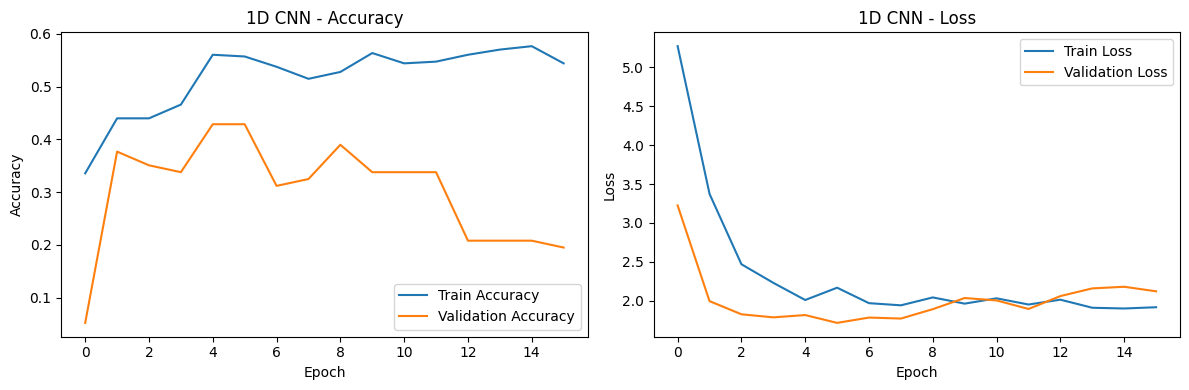


Plotting LSTM Training History...


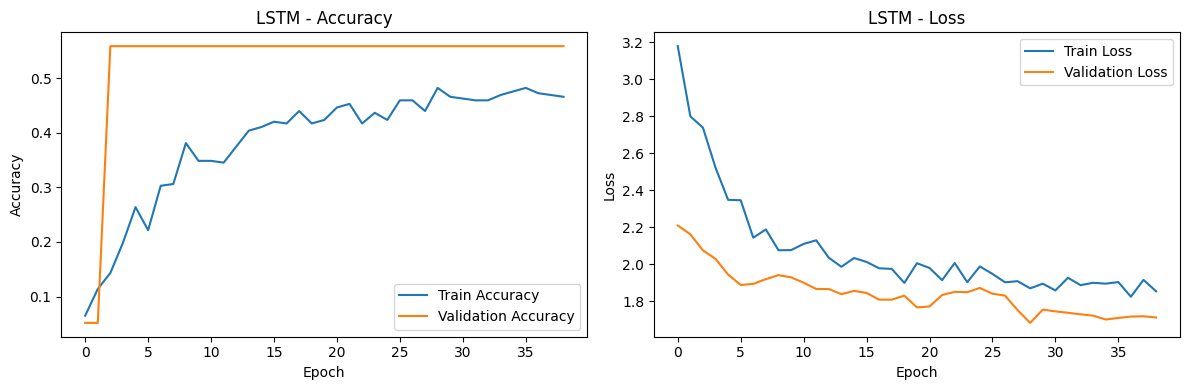


--- Evaluating 1D CNN Model on Test Set ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step 
1D CNN Test Accuracy: 0.4896
1D CNN Test F1-score (Macro): 0.2698
1D CNN Test Inference Time: 1.3459 seconds

1D CNN Classification Report (Test Set):
                precision    recall  f1-score   support

       healthy       0.63      0.75      0.69        48
     notchlong       0.00      0.00      0.00         6
    notchshort       0.20      0.17      0.18         6
       scracth       0.14      0.17      0.15         6
 singlecutlong       0.67      0.67      0.67         6
singlecutshort       0.00      0.00      0.00         6
    twocutlong       1.00      0.33      0.50         6
   twocutshort       0.00      0.00      0.00         6
        warped       0.16      0.50      0.24         6

      accuracy                           0.49        96
     macro avg       0.31      0.29      0.27        96
  weighted avg       0.45      0.49      0.45        96



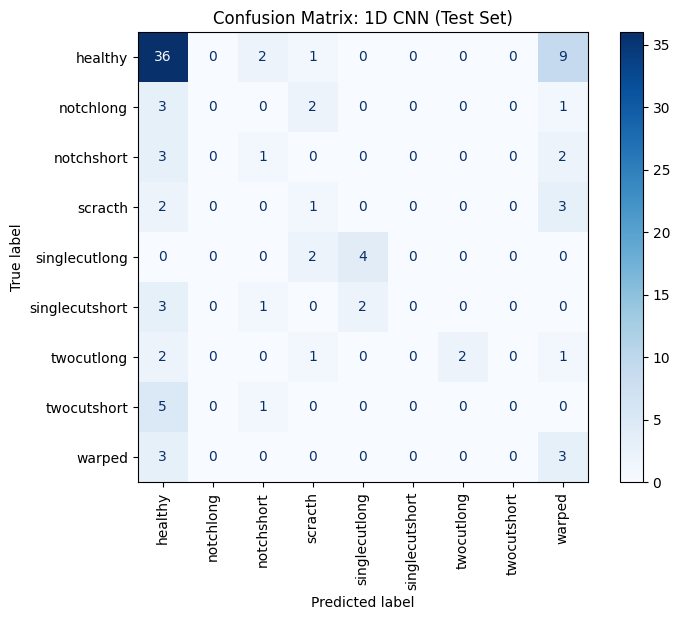


--- Evaluating LSTM Model on Test Set ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
LSTM Test Accuracy: 0.5000
LSTM Test F1-score (Macro): 0.0741
LSTM Test Inference Time: 0.6838 seconds

LSTM Classification Report (Test Set):
                precision    recall  f1-score   support

       healthy       0.50      1.00      0.67        48
     notchlong       0.00      0.00      0.00         6
    notchshort       0.00      0.00      0.00         6
       scracth       0.00      0.00      0.00         6
 singlecutlong       0.00      0.00      0.00         6
singlecutshort       0.00      0.00      0.00         6
    twocutlong       0.00      0.00      0.00         6
   twocutshort       0.00      0.00      0.00         6
        warped       0.00      0.00      0.00         6

      accuracy                           0.50        96
     macro avg       0.06      0.11      0.07        96
  weighted avg       0.25      0.50      0.33        96



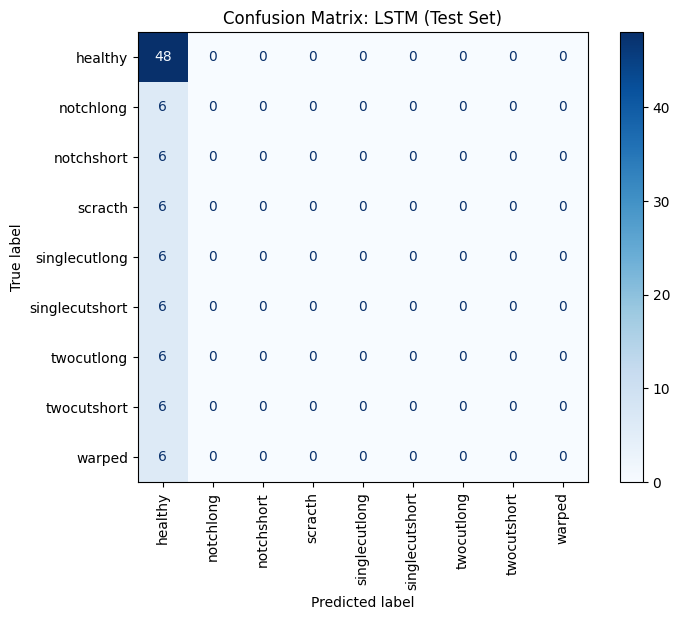

In [8]:
import time
import matplotlib.pyplot as plt

EPOCHS = 50 # Adjust as needed, start with a moderate number
BATCH_SIZE = 32 # Common batch size

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Model checkpoint to save the best model during training (optional, but good practice)
CNN_MODEL_PATH = os.path.join('outputs', 'pm980_cnn_best_model.keras')
LSTM_MODEL_PATH = os.path.join('outputs', 'pm980_lstm_best_model.keras')

#Train 1D CNN Model
print("\n--- Training 1D CNN Model ---")
history_cnn = cnn_model.fit(
    X_train_scaled, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Save the final trained CNN model (after early stopping restored best weights)
CNN_MODEL_FINAL_PATH = os.path.join('outputs', 'pm980_cnn_final_model.keras')
os.makedirs('outputs', exist_ok=True)
cnn_model.save(CNN_MODEL_FINAL_PATH)
print(f"Final 1D CNN model saved to {CNN_MODEL_FINAL_PATH}")

#Train LSTM Model
print("\n--- Training LSTM Model ---")
history_lstm = lstm_model.fit(
    X_train_scaled, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Save the final trained LSTM model
LSTM_MODEL_FINAL_PATH = os.path.join('outputs', 'pm980_lstm_final_model.keras')
lstm_model.save(LSTM_MODEL_FINAL_PATH)
print(f"Final LSTM model saved to {LSTM_MODEL_FINAL_PATH}")

# Plot Training History Helper
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\nPlotting CNN Training History...")
plot_training_history(history_cnn, "1D CNN")
print("\nPlotting LSTM Training History...")
plot_training_history(history_lstm, "LSTM")


# Evaluate Models on Test Data

# --- CNN Evaluation ---
print("\n--- Evaluating 1D CNN Model on Test Set ---")
start_time_cnn_test = time.time()
y_pred_one_hot_cnn = cnn_model.predict(X_test_scaled, batch_size=BATCH_SIZE)
cnn_test_time = time.time() - start_time_cnn_test
y_pred_classes_cnn = np.argmax(y_pred_one_hot_cnn, axis=1)
y_test_classes = np.argmax(y_test, axis=1) # Convert one-hot test labels back to class indices

cnn_test_accuracy = accuracy_score(y_test_classes, y_pred_classes_cnn)
cnn_test_f1_macro = f1_score(y_test_classes, y_pred_classes_cnn, average='macro', zero_division=0)

print(f"1D CNN Test Accuracy: {cnn_test_accuracy:.4f}")
print(f"1D CNN Test F1-score (Macro): {cnn_test_f1_macro:.4f}")
print(f"1D CNN Test Inference Time: {cnn_test_time:.4f} seconds")
print("\n1D CNN Classification Report (Test Set):")
print(classification_report(y_test_classes, y_pred_classes_cnn, target_names=CLASS_NAMES, zero_division=0))

# Confusion Matrix for CNN
cm_cnn = confusion_matrix(y_test_classes, y_pred_classes_cnn)
disp_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=CLASS_NAMES)
fig_cnn, ax_cnn = plt.subplots(figsize=(max(8, 9*0.8), max(6, 9*0.7)))
disp_cnn.plot(ax=ax_cnn, cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix: 1D CNN (Test Set)')
plt.tight_layout()
plt.show()


#  LSTM Evaluation
print("\n--- Evaluating LSTM Model on Test Set ---")
# loaded_lstm_model = tf.keras.models.load_model(LSTM_MODEL_FINAL_PATH)

start_time_lstm_test = time.time()
y_pred_one_hot_lstm = lstm_model.predict(X_test_scaled, batch_size=BATCH_SIZE)
lstm_test_time = time.time() - start_time_lstm_test
y_pred_classes_lstm = np.argmax(y_pred_one_hot_lstm, axis=1)
# y_test_classes is already defined

lstm_test_accuracy = accuracy_score(y_test_classes, y_pred_classes_lstm)
lstm_test_f1_macro = f1_score(y_test_classes, y_pred_classes_lstm, average='macro', zero_division=0)

print(f"LSTM Test Accuracy: {lstm_test_accuracy:.4f}")
print(f"LSTM Test F1-score (Macro): {lstm_test_f1_macro:.4f}")
print(f"LSTM Test Inference Time: {lstm_test_time:.4f} seconds")
print("\nLSTM Classification Report (Test Set):")
print(classification_report(y_test_classes, y_pred_classes_lstm, target_names=CLASS_NAMES, zero_division=0))

# Confusion Matrix for LSTM
cm_lstm = confusion_matrix(y_test_classes, y_pred_classes_lstm)
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm, display_labels=CLASS_NAMES)
fig_lstm, ax_lstm = plt.subplots(figsize=(max(8, 9*0.8), max(6, 9*0.7)))
disp_lstm.plot(ax=ax_lstm, cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix: LSTM (Test Set)')
plt.tight_layout()
plt.show()